In [2]:
import pandas as pd
import matplotlib.pylab as plt
import requests
import numpy as np
import seaborn as sns

import missingno as msno
import datetime

import ee
# ee.Authenticate()
ee.Initialize()

## Download Streamflow data
San Lorenzo River, Santa Cruz County, California
USGS streamflow data is in *local* time... so loses an hour or missing an hour at each time zone. Change data to be in PST so it matches clock time in the winter when the most "action" is. 

In [3]:
# import Santa Cruz streamflow data for San Lorenzo River
site = '11161000'
code = '00060'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2024-06-18T00:00:00.000-07:00'

usgs_water_api = ("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=" + site +  "&parameterCd=" + code + 
                  "&siteStatus=all&startDT=" + startDT + "&endDT=" + endDT)
api_response = requests.get(usgs_water_api)

water_data = api_response.json()
data_only = water_data['value']['timeSeries'][0]['values'][0]['value']

streamflow_SC_raw = pd.DataFrame(data_only).sort_values('dateTime')
streamflow_SC_raw.head()

,value,qualifiers,dateTime
0,4.40,"[A, [91]]",1987-10-01T00:15:00.000-07:00
1,4.40,"[A, [91]]",1987-10-01T00:30:00.000-07:00
2,3.90,"[A, [91]]",1987-10-01T00:45:00.000-07:00
3,3.70,"[A, [91]]",1987-10-01T01:00:00.000-07:00
4,3.20,"[A, [91]]",1987-10-01T01:15:00.000-07:00


In [4]:
datetime.datetime.now()

datetime.datetime(2024, 7, 10, 14, 27, 15, 891933)

In [5]:
#import streamflow data for San Lorenzo River at Big Trees
site = '11160500'
code = '00060'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2024-06-18T00:00:00.000-07:00'

usgs_water_api = ("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=" + site +  "&parameterCd=" + code + 
                  "&siteStatus=all&startDT=" + startDT + "&endDT=" + endDT)
api_response = requests.get(usgs_water_api)

water_data = api_response.json()
data_only = water_data['value']['timeSeries'][0]['values'][0]['value']

streamflow_BT_raw = pd.DataFrame(data_only).sort_values('dateTime')
streamflow_BT_raw.head()


,value,qualifiers,dateTime
0,9.40,"[A, [91]]",1987-10-01T00:15:00.000-07:00
1,9.40,"[A, [91]]",1987-10-01T00:30:00.000-07:00
2,9.40,"[A, [91]]",1987-10-01T00:45:00.000-07:00
3,9.40,"[A, [91]]",1987-10-01T01:00:00.000-07:00
4,9.40,"[A, [91]]",1987-10-01T01:15:00.000-07:00


In [6]:
# combine streamflow data into one df

def process_streamflow(streamflow_data):
    #create datetime index
    streamflow_data.index = pd.to_datetime([x[0:-6] for x in streamflow_data['dateTime']]) 

    # convert data to PST (-08:00) 
    streamflow_data['tz'] = [x[-6::] for x in streamflow_data['dateTime']]
    streamflow_data.loc[streamflow_data.tz == '-07:00', :].index = streamflow_data.loc[streamflow_data.tz == '-07:00', :].index - pd.Timedelta(1, 'hour')

    #rename cols
    col_mapper = {'value': 'q_cfs', 'qualifiers': 'code'}
    streamflow_data.rename(col_mapper, axis=1, inplace=True) # rename cols

    #cfs to numeric 
    streamflow_data['q_cfs'] = streamflow_data['q_cfs'].apply(pd.to_numeric)

    # resample to 15 min to account for timechange dupes
    streamflow_data_resample = streamflow_data.resample('15min').agg({'q_cfs': 'mean',
                                                                     'code': 'first', 
                                                                     'dateTime': 'first', 
                                                                     'tz': 'first'})

    streamflow_data_resample.drop(['dateTime'], axis=1, inplace=True)

    streamflow_data_resample = streamflow_data_resample.resample('1D').agg({'q_cfs': 'max',
                                                                             'code': 'first', 
                                                                             'tz': 'first'})

    streamflow_data_resample.rename({'q_cfs': 'q_cfs_peak'}, axis=1, inplace=True)
    
    return streamflow_data_resample


streamflow_BT = process_streamflow(streamflow_BT_raw)
streamflow_SC = process_streamflow(streamflow_SC_raw)


streamflow = pd.merge(streamflow_BT, streamflow_SC, how='outer', left_index=True, right_index=True, suffixes=['_BT', '_SC'])

streamflow.head()

,q_cfs_peak_BT,code_BT,tz_BT,q_cfs_peak_SC,code_SC,tz_SC
1987-10-01,41.0,"[A, [91]]",-07:00,9.40,"[A, [91]]",-07:00
1987-10-02,10.0,"[A, [92]]",-07:00,4.90,"[A, [91]]",-07:00
1987-10-03,11.0,"[A, [91]]",-07:00,2.30,"[A, [91]]",-07:00
1987-10-04,9.9,"[A, [91]]",-07:00,0.99,"[A, [91]]",-07:00
1987-10-05,10.0,"[A, [92]]",-07:00,1.40,"[A, [91]]",-07:00


## download precipitation data from Ben Lomond Station near Felton, CA within the San Lorenzo watershed. 
Data is event-based data, with timestamp saved for each tip of the rain tipping bucket. Code below recalculated to incremental data resampled to every 15 minutes. 

In [7]:
#download Ben Lomond precip data
cdec_bl_api = 'https://cdec.water.ca.gov/dynamicapp/req/JSONDataServlet?Stations=BLN&SensorNums=16&dur_code=E&Start=1997-12-10&End=2024-06-18'

response = requests.get(cdec_bl_api)
rain_data = response.json()


In [8]:
## clean event-based rain data (tip events to 15 minute data)
event_rain = pd.DataFrame(rain_data)
event_rain['dt'] = pd.to_datetime(event_rain['date'])
event_rain['inc'] = event_rain['value'].diff()

event_rain.sort_values('inc')
event_rain_cleaned = event_rain.loc[event_rain['dt'] > pd.to_datetime('2008-10-01'), :]
event_rain_cleaned.loc[event_rain_cleaned.inc < 0, 'inc'] = 0 #negative increments are when tip resets to zero
event_rain_cleaned.loc[event_rain_cleaned.inc >10, 'inc'] = 0 # greater than 10 are when cumulative precip jumps back up to cumulative after data drop

(14153.0, 19935.0)

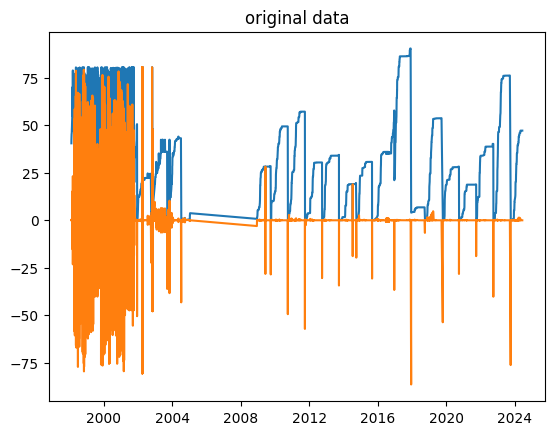

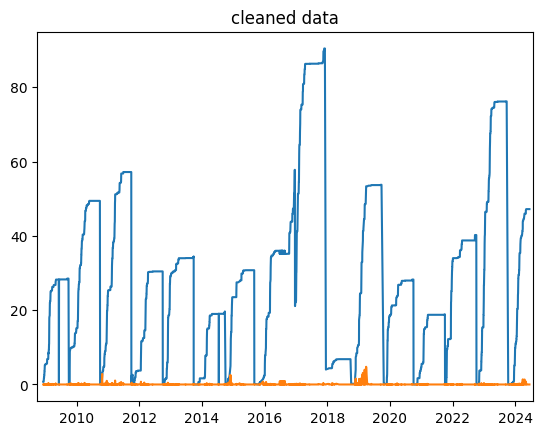

In [9]:
##use this plot code to explore data and iterate on cleaning above. I rerun multiple times to look at various parts of data
f, ax = plt.subplots(1, 1)
ax.plot(event_rain.dt, event_rain['value'])
ax.plot(event_rain.dt, event_rain['inc'])
ax.set_title('original data')

f, ax2 = plt.subplots(1, 1)
ax2.plot(event_rain_cleaned.dt, event_rain_cleaned['value'])
ax2.plot(event_rain_cleaned.dt, event_rain_cleaned.inc)
ax2.set_title('cleaned data')
ax2.set_xlim(pd.to_datetime('2008-10-01'), pd.to_datetime('2024-07-31'))

# ax2.xlim(pd.to_datetime('2018-08-01'), pd.to_datetime('2019-06-01'))
# ax2.ylim(-1, 5)

In [10]:
event_rain_cleaned.head()

,stationId,durCode,SENSOR_NUM,sensorType,date,obsDate,value,dataFlag,units,dt,inc
16292,BLN,E,16,RAINTIP,2008-12-10 3:34,2008-12-10 3:34,0.71,,INCHES,2008-12-10 03:34:00,0.0
16293,BLN,E,16,RAINTIP,2008-12-10 15:34,2008-12-10 15:34,0.71,,INCHES,2008-12-10 15:34:00,0.0
16294,BLN,E,16,RAINTIP,2008-12-11 3:34,2008-12-11 3:34,0.71,,INCHES,2008-12-11 03:34:00,0.0
16295,BLN,E,16,RAINTIP,2008-12-11 15:34,2008-12-11 15:34,0.71,,INCHES,2008-12-11 15:34:00,0.0
16296,BLN,E,16,RAINTIP,2008-12-12 3:34,2008-12-12 3:34,0.71,,INCHES,2008-12-12 03:34:00,0.0


In [11]:
# resample event data to 15min; check min and max are reasonable and consistent with plots above 
event_rain_cleaned.index = event_rain_cleaned.dt
rain_resample = event_rain_cleaned[['inc']].resample('1D').sum()
rain_resample.rename({'inc': 'precip_in'}, axis=1, inplace=True)
rain_resample.describe()


,precip_in
count,5667.000000
mean,0.116917
std,0.488784
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.020000


## Add NDWI Values
Downloaded from climateengine.org, median NDWI (Green/NIR) over the whole watershed. 
Watershed boundary from: https://purl.stanford.edu/cp847hc0870

In [92]:
ndwi = pd.read_csv('NDWI_GreenNIR_watershed.csv', parse_dates=True, index_col=0)
ndwi.columns = ['ndwi_watershed_green_nir']
ndwi.loc[pd.to_datetime('2008-10-01'), 'ndwi_watershed_green_nir'] = 0

# ndwi_resample = ndwi.resample('1D').ffill()
ndwi_resample

,ndwi_watershed_green_nir
2008-10-01,0.0000
2008-10-02,0.0000
2008-10-03,-0.3965
2008-10-04,-0.3965
2008-10-05,-0.3965
...,...
2024-06-13,-0.7155
2024-06-14,-0.7155
2024-06-15,-0.7155
2024-06-16,-0.7155


## Merge; Check for missing values
Data prior to water year 2008 is very messy, discard. 
Missing precip is filled with zero 
Missing streamflow is linearly interpolated. 

In [93]:
# combine all data into one df 

hydro_data1 = pd.merge(rain_resample, streamflow, how='outer', left_index=True, right_index=True)
hydro_data = pd.merge(hydro_data1, ndwi, how='outer', left_index=True, right_index=True)
hydro_data['ndwi_watershed_green_nir'] = hydro_data['ndwi_watershed_green_nir'].ffill()

hydro_data.head()

,precip_in,q_cfs_peak_BT,code_BT,tz_BT,q_cfs_peak_SC,code_SC,tz_SC,ndwi_watershed_green_nir
1987-10-01,NaN,41.0,"[A, [91]]",-07:00,9.40,"[A, [91]]",-07:00,NaN
1987-10-02,NaN,10.0,"[A, [92]]",-07:00,4.90,"[A, [91]]",-07:00,NaN
1987-10-03,NaN,11.0,"[A, [91]]",-07:00,2.30,"[A, [91]]",-07:00,NaN
1987-10-04,NaN,9.9,"[A, [91]]",-07:00,0.99,"[A, [91]]",-07:00,NaN
1987-10-05,NaN,10.0,"[A, [92]]",-07:00,1.40,"[A, [91]]",-07:00,NaN


In [94]:
# check for missing
hydro_data.isna().sum()

precip_in                   7744
q_cfs_peak_BT                 88
code_BT                       88
tz_BT                         88
q_cfs_peak_SC                331
code_SC                      331
tz_SC                        331
ndwi_watershed_green_nir    7671
dtype: int64

<Axes: >

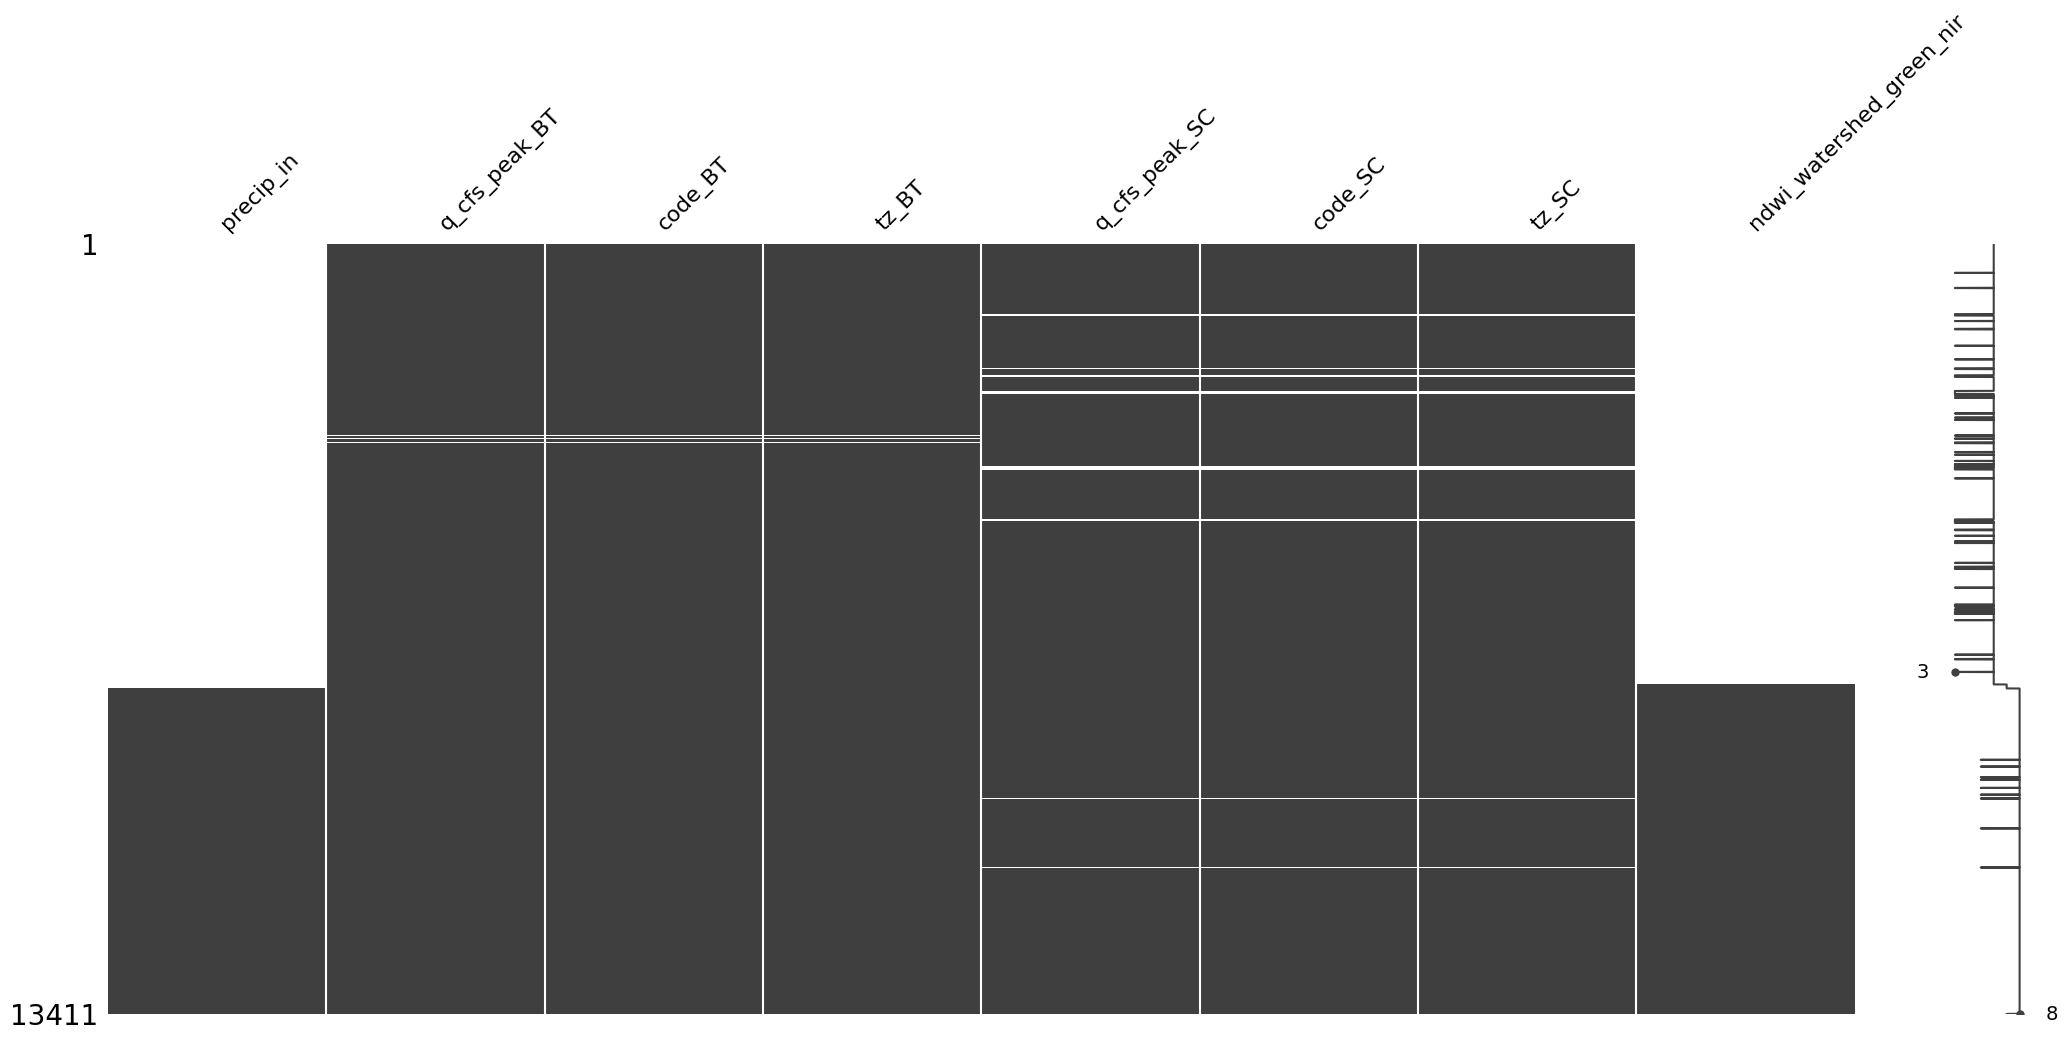

In [95]:
msno.matrix(hydro_data)

precip_in                   73
q_cfs_peak_BT                2
code_BT                      2
tz_BT                        2
q_cfs_peak_SC               15
code_SC                     15
tz_SC                       15
ndwi_watershed_green_nir     0
dtype: int64

<Axes: >

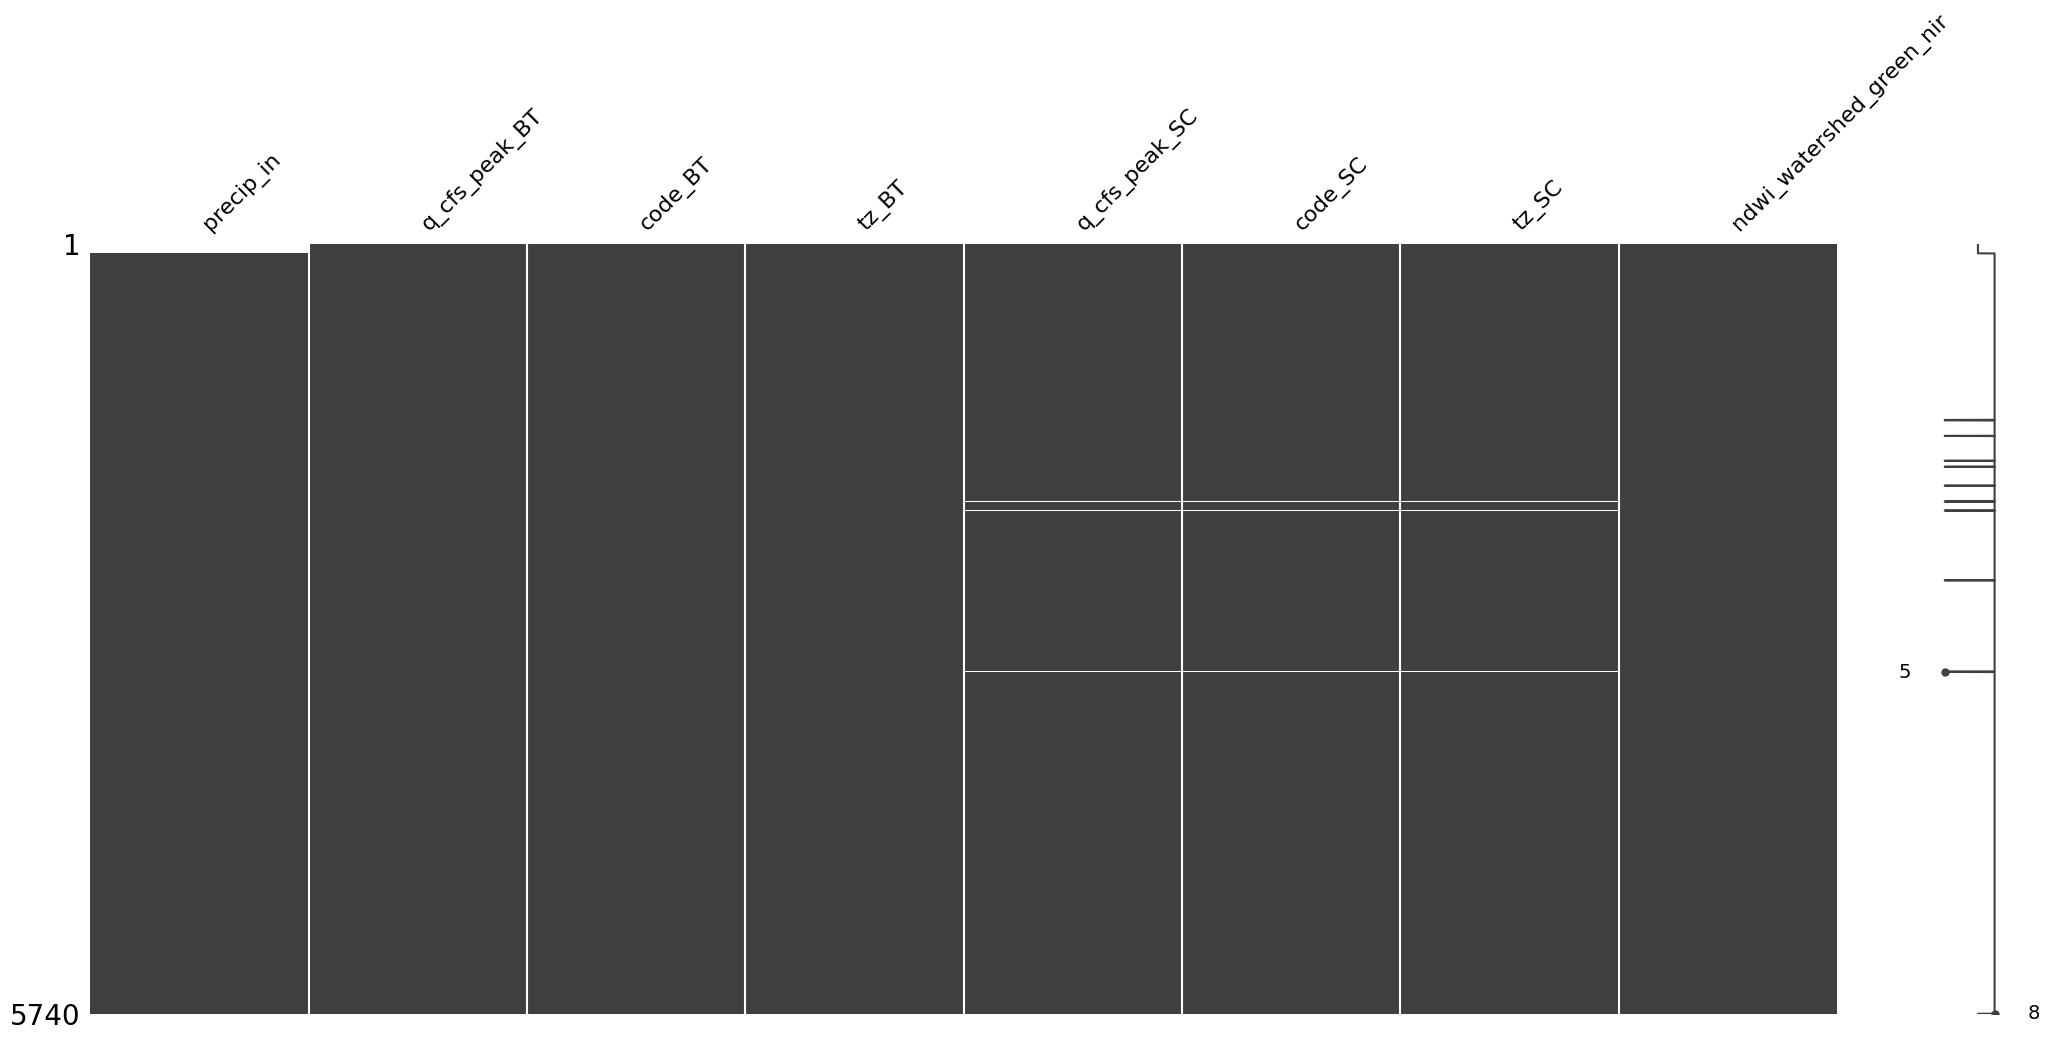

In [96]:
## keep only wy 2008 on; check for missing in that time period (much less)
hydro_data = hydro_data.loc[(hydro_data.index >= pd.to_datetime('2008-10-01'))]
display(hydro_data.isna().sum())
msno.matrix(hydro_data)

In [97]:
### fill precip with zero, it's incremental rainfall, so zero is appropriate
hydro_data.precip_in = hydro_data.precip_in.fillna(0)
display(hydro_data.isna().sum())



precip_in                    0
q_cfs_peak_BT                2
code_BT                      2
tz_BT                        2
q_cfs_peak_SC               15
code_SC                     15
tz_SC                       15
ndwi_watershed_green_nir     0
dtype: int64

precip_in                   float64
q_cfs_peak_BT               float64
code_BT                      object
tz_BT                        object
q_cfs_peak_SC               float64
code_SC                      object
tz_SC                        object
ndwi_watershed_green_nir    float64
dtype: object

<Axes: >

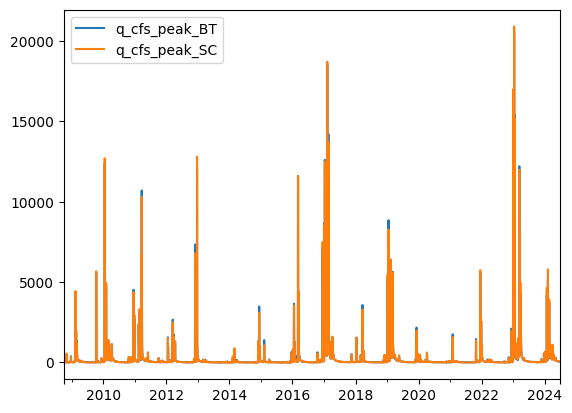

In [98]:
## code and datetime not important for modeling, so look at discharge
# hydro_data[['q_cfs_BT', 'q_cfs_SC']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].apply(pd.to_numeric)
display(hydro_data.dtypes)
hydro_data.plot(y=['q_cfs_peak_BT', 'q_cfs_peak_SC'])
# plt.yscale('log')

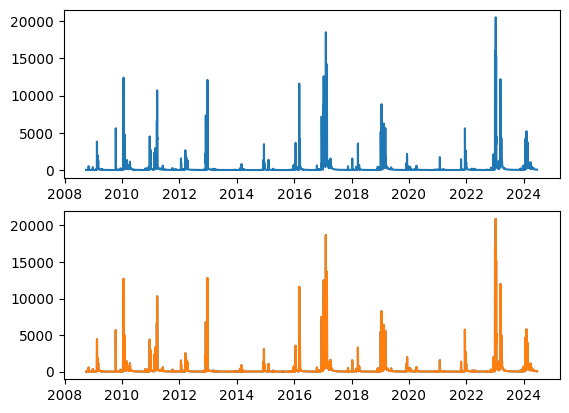

In [99]:
hydro_data[['q_cfs_peak_BT_int', 'q_cfs_peak_SC_int']] = hydro_data[['q_cfs_peak_BT', 'q_cfs_peak_SC']].interpolate()
# hydro_data[['q_cfs_BT', 'q_cfs_SC']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].fillna(-999)
f, ax = plt.subplots(2, 1)
ax[0].plot(hydro_data[['q_cfs_peak_BT']])
# ax[0].plot(hydro_data.q_cfs_BT.isna() * 10000 - 5000, linestyle='', marker='.')
ax[1].plot(hydro_data[['q_cfs_peak_SC', 'q_cfs_peak_SC_int']])
# ax[0].set_yscale('log')
# ax[0].set_xlim(pd.to_datetime('2018-04-01'), pd.to_datetime('2018-05-01'))

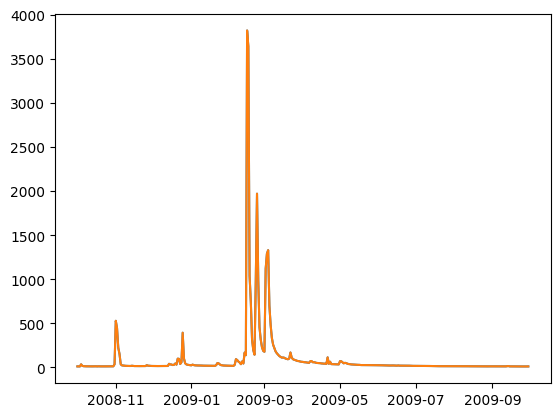

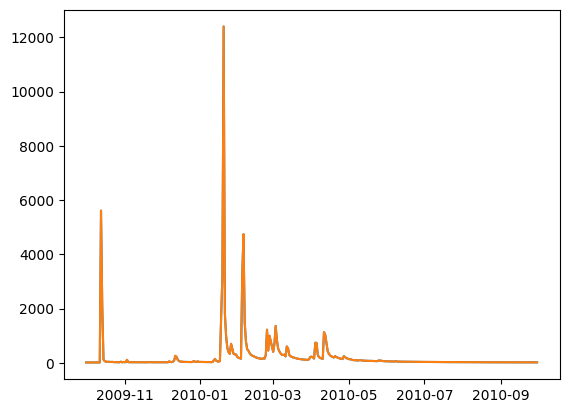

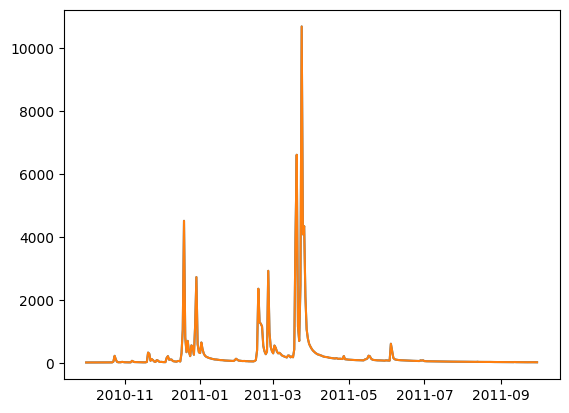

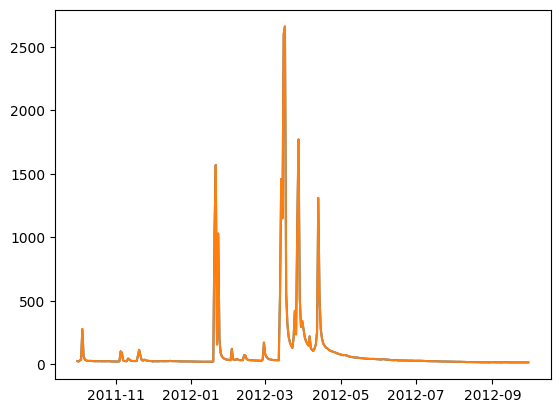

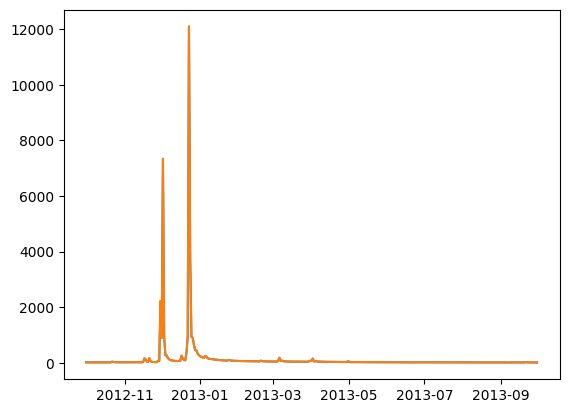

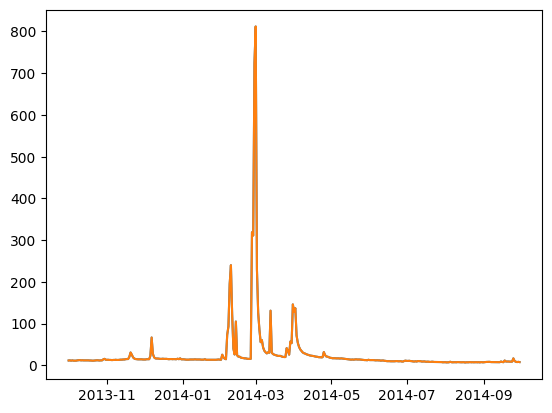

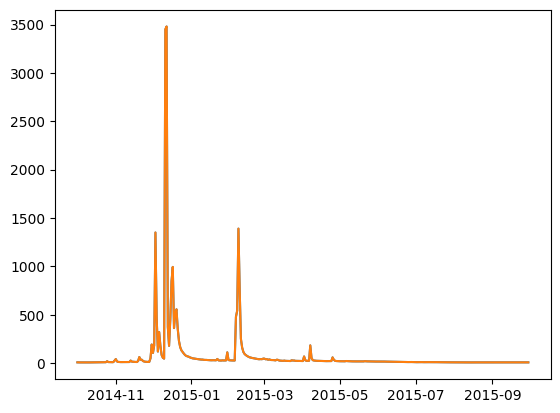

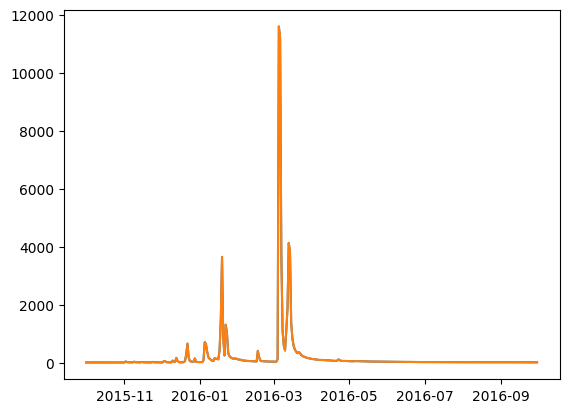

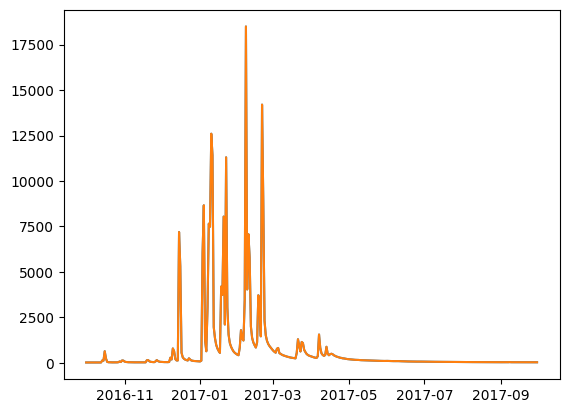

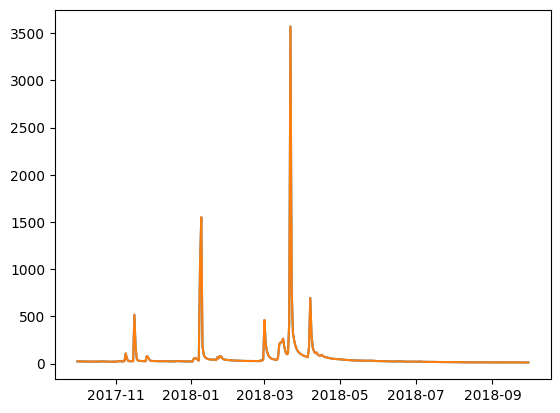

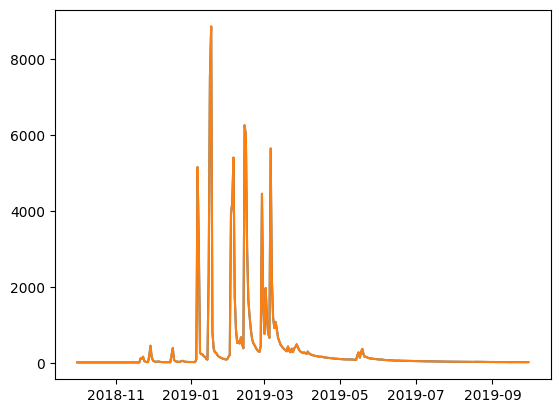

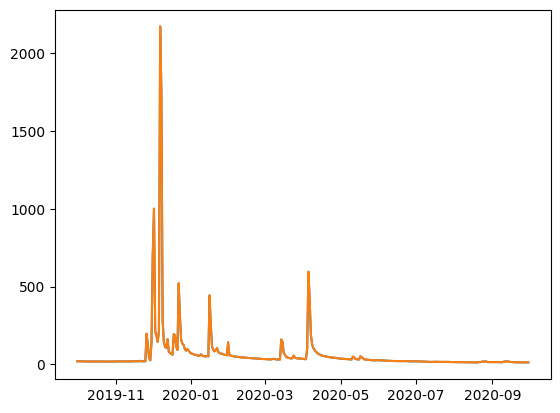

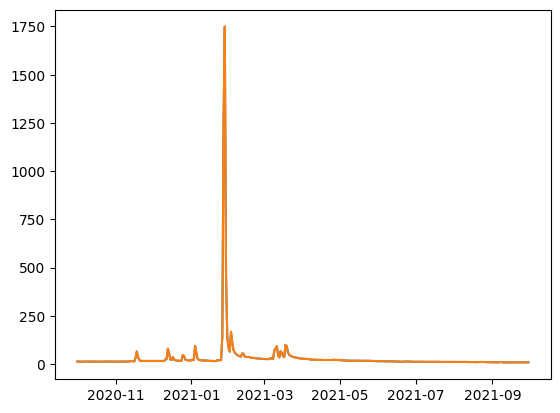

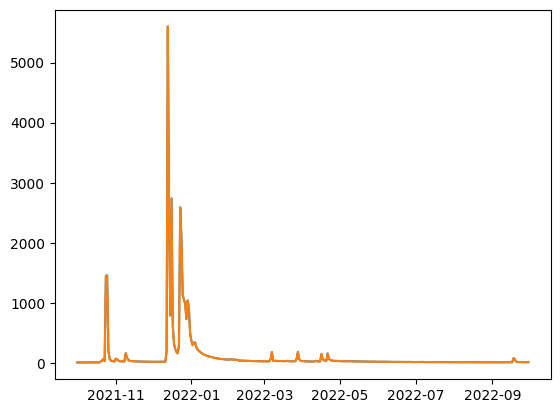

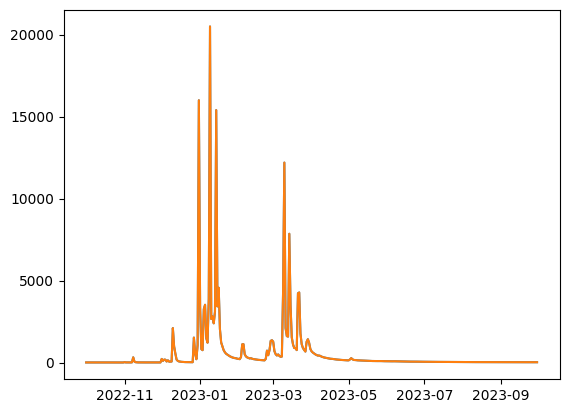

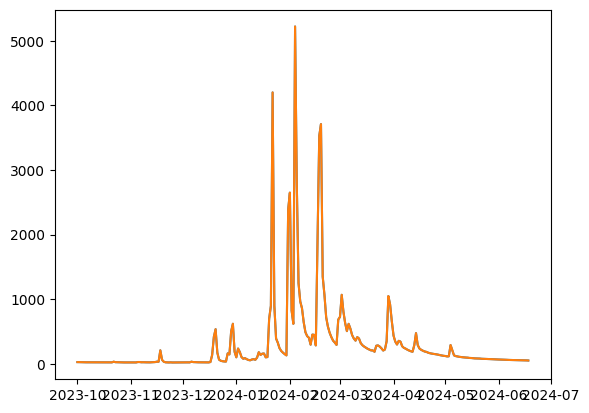

In [100]:
### plot each water year to visually check for interpolation problems

hydro_data['cy'] = hydro_data.index.year
hydro_data['month'] = hydro_data.index.month

hydro_data['wy'] = hydro_data.cy
hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'wy'] = hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'cy'] + 1

for wy in hydro_data['wy'].unique():
    f, ax = plt.subplots(1, 1)
    data_wy = hydro_data.loc[hydro_data['wy'] == wy, :]
    ax.plot(data_wy.index, data_wy[['q_cfs_peak_BT', 'q_cfs_peak_BT_int']])

In [101]:
#how many consecutive missing q values?
a = hydro_data[['q_cfs_peak_BT', 'q_cfs_peak_SC']].isna()
df1 = a.cumsum()-a.cumsum().where(~a).ffill().fillna(0).astype(int)
df1.max() # days


q_cfs_peak_BT    1
q_cfs_peak_SC    4
dtype: int64

In [102]:
hydro_data.isna().sum()
hydro_data_clean = hydro_data.drop(['q_cfs_peak_BT', 'code_BT', 'q_cfs_peak_SC', 'code_SC', 'tz_BT', 'tz_SC'], axis=1)

hydro_data_clean

,precip_in,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,month,wy
2008-10-01,0.0,0.0000,12.2,1.43,2008,10,2009
2008-10-02,0.0,0.0000,11.6,2.01,2008,10,2009
2008-10-03,0.0,-0.3965,11.9,1.61,2008,10,2009
2008-10-04,0.0,-0.3965,35.6,23.80,2008,10,2009
2008-10-05,0.0,-0.3965,18.2,24.40,2008,10,2009
...,...,...,...,...,...,...,...
2024-06-14,0.0,-0.7155,57.9,59.90,2024,6,2024
2024-06-15,0.0,-0.7155,56.7,56.10,2024,6,2024
2024-06-16,0.0,-0.7155,56.1,57.00,2024,6,2024
2024-06-17,0.0,-0.7088,55.5,57.00,2024,6,2024


## Check for outliers
Weird binning makes date features look uneven, but they aren't. Verified below. 

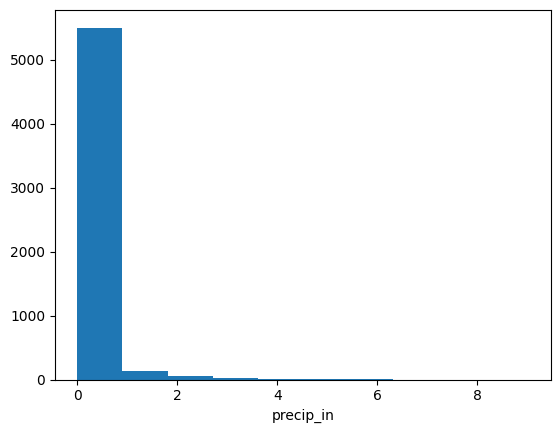

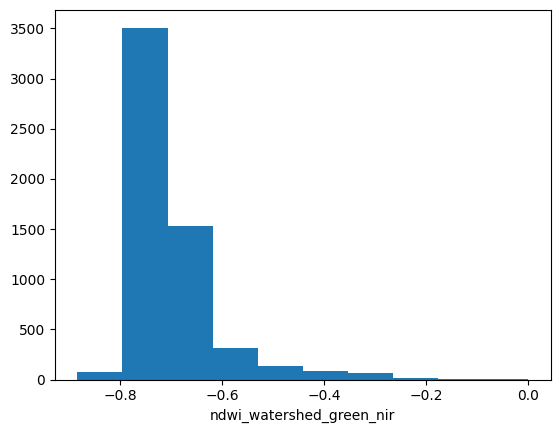

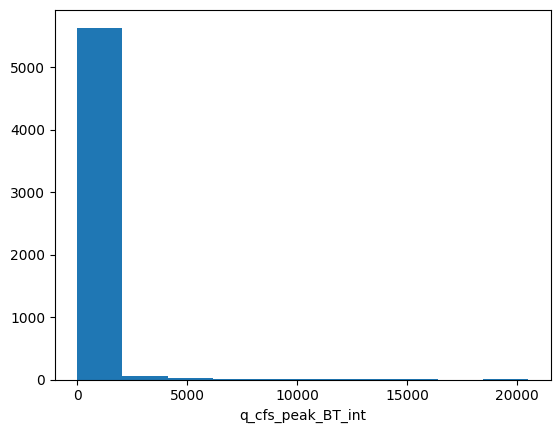

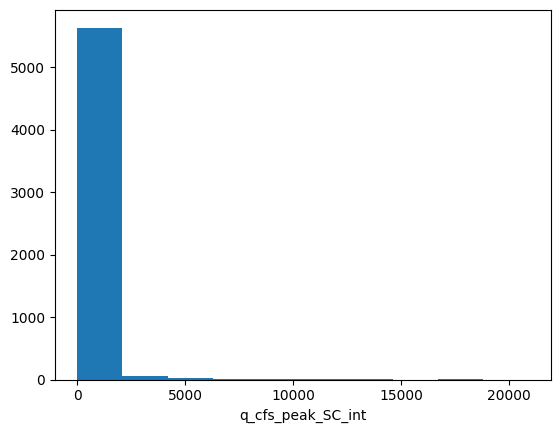

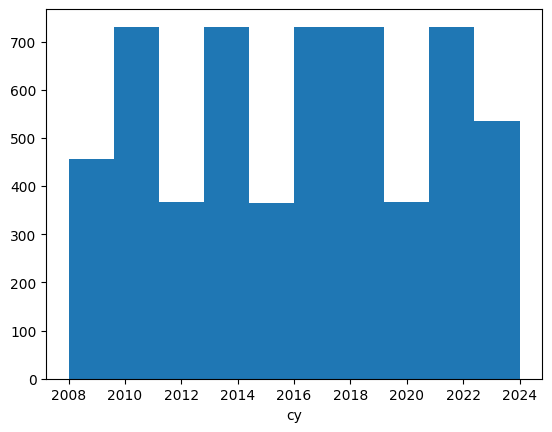

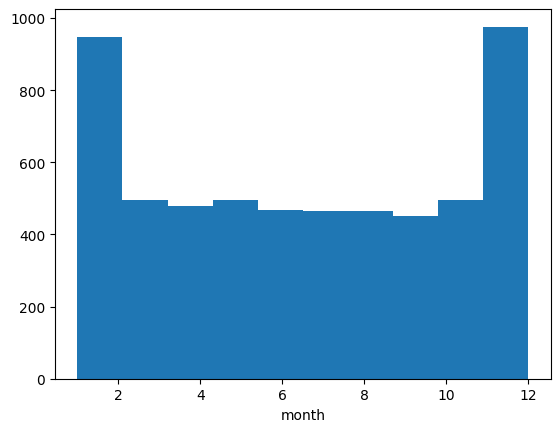

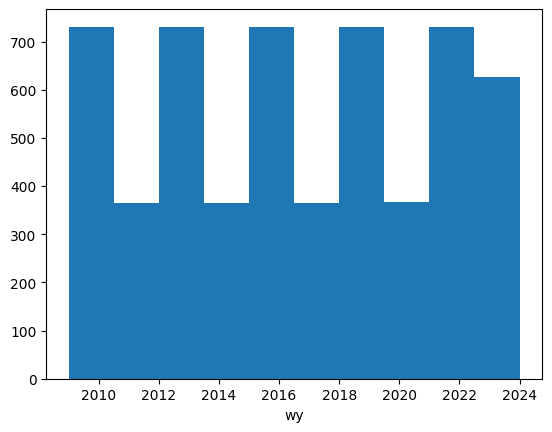

In [103]:
##outliers

for n in hydro_data_clean.columns:
    f, ax = plt.subplots(1, 1)
    ax.hist(hydro_data_clean[n])
    ax.set_xlabel(n)

# hydro_data_clean.head(20)

In [104]:
print('timestamp duplicates: ', hydro_data_clean.index.duplicated().sum())
display(hydro_data_clean.wy.value_counts())
display(hydro_data_clean.month.value_counts())

## no timestamp duplicates. Weird spikey histograms are binning issues. 

timestamp duplicates:  0


wy
2012    366
2016    366
2020    366
2009    365
2010    365
2011    365
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
2022    365
2023    365
2024    262
Name: count, dtype: int64

month
10    496
12    496
1     496
3     496
5     496
11    480
4     480
6     468
7     465
8     465
2     452
9     450
Name: count, dtype: int64

## Add relevant wildfires and estimate percent of watershed burned. 

In [105]:
## wildfires
wildfire_percent = {2017: 341.136 / 88320.0, # https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac/about
                   2020: 0.2} # https://www.cityofsantacruz.com/government/city-departments/water/water-quality/czu-fire-water-quality

# wildfire_percent = pd.DataFrame(wildfire_percent, index=[0, 1])
wildfire_percent

{2017: 0.0038625000000000005, 2020: 0.2}

## Download drought index data 
from https://www.drought.gov/historical-information?dataset=0&selectedDateUSDM=20240618
for Santa Cruz County

In [106]:
#drought data, SC county

drought_data = pd.read_csv('USDM-06087.csv', parse_dates=['ValidStart', 'ValidEnd'])
drought_data.rename({'ValidStart': 'week_start'}, axis=1, inplace=True)
drought_data.index = drought_data.week_start
drought_data = drought_data[['D0', 'D1', 'D2', 'D3', 'D4']].copy()
drought_data = drought_data.sort_index()
drought_data#.loc[pd.to_datetime('2008-10-01'), :]

,D0,D1,D2,D3,D4
week_start,,,,,
2000-01-04,0.0,0.0,0.0,0.0,0.0
2000-01-11,0.0,0.0,0.0,0.0,0.0
2000-01-18,0.0,0.0,0.0,0.0,0.0
2000-01-25,0.0,0.0,0.0,0.0,0.0
2000-02-01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2024-05-21,0.0,0.0,0.0,0.0,0.0
2024-05-28,0.0,0.0,0.0,0.0,0.0
2024-06-04,0.0,0.0,0.0,0.0,0.0


In [107]:
#merge drought and wildfire data
drought_data_resample = drought_data.resample('1D').ffill()
data = pd.merge(hydro_data_clean, drought_data_resample, left_index=True, right_index=True, how='left')
data = pd.merge(hydro_data_clean, drought_data_resample, left_index=True, right_index=True, how='left')

for k in wildfire_percent.keys():
    data.loc[data['wy'] == k, 'wildfire_percent'] = wildfire_percent[k]

data[['wildfire_percent']] = data[['wildfire_percent']].fillna(0)
data.head()

,precip_in,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,month,wy,D0,D1,D2,D3,D4,wildfire_percent
2008-10-01,0.0,0.0000,12.2,1.43,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-02,0.0,0.0000,11.6,2.01,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-03,0.0,-0.3965,11.9,1.61,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-04,0.0,-0.3965,35.6,23.80,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-05,0.0,-0.3965,18.2,24.40,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0


In [108]:
data.loc[data['ndwi_watershed_green_nir'].isna(), 'ndwi_watershed_green_nir']

Series([], Freq: D, Name: ndwi_watershed_green_nir, dtype: float64)

In [109]:
#final nan/duplicate checks

display(data.isna().sum())
print('duplicates: ', data.index.duplicated().sum())

precip_in                   0
ndwi_watershed_green_nir    0
q_cfs_peak_BT_int           0
q_cfs_peak_SC_int           0
cy                          0
month                       0
wy                          0
D0                          0
D1                          0
D2                          0
D3                          0
D4                          0
wildfire_percent            0
dtype: int64

duplicates:  0


## Check variable correlations
Will likely use LSTM so checking lagged correlation as well

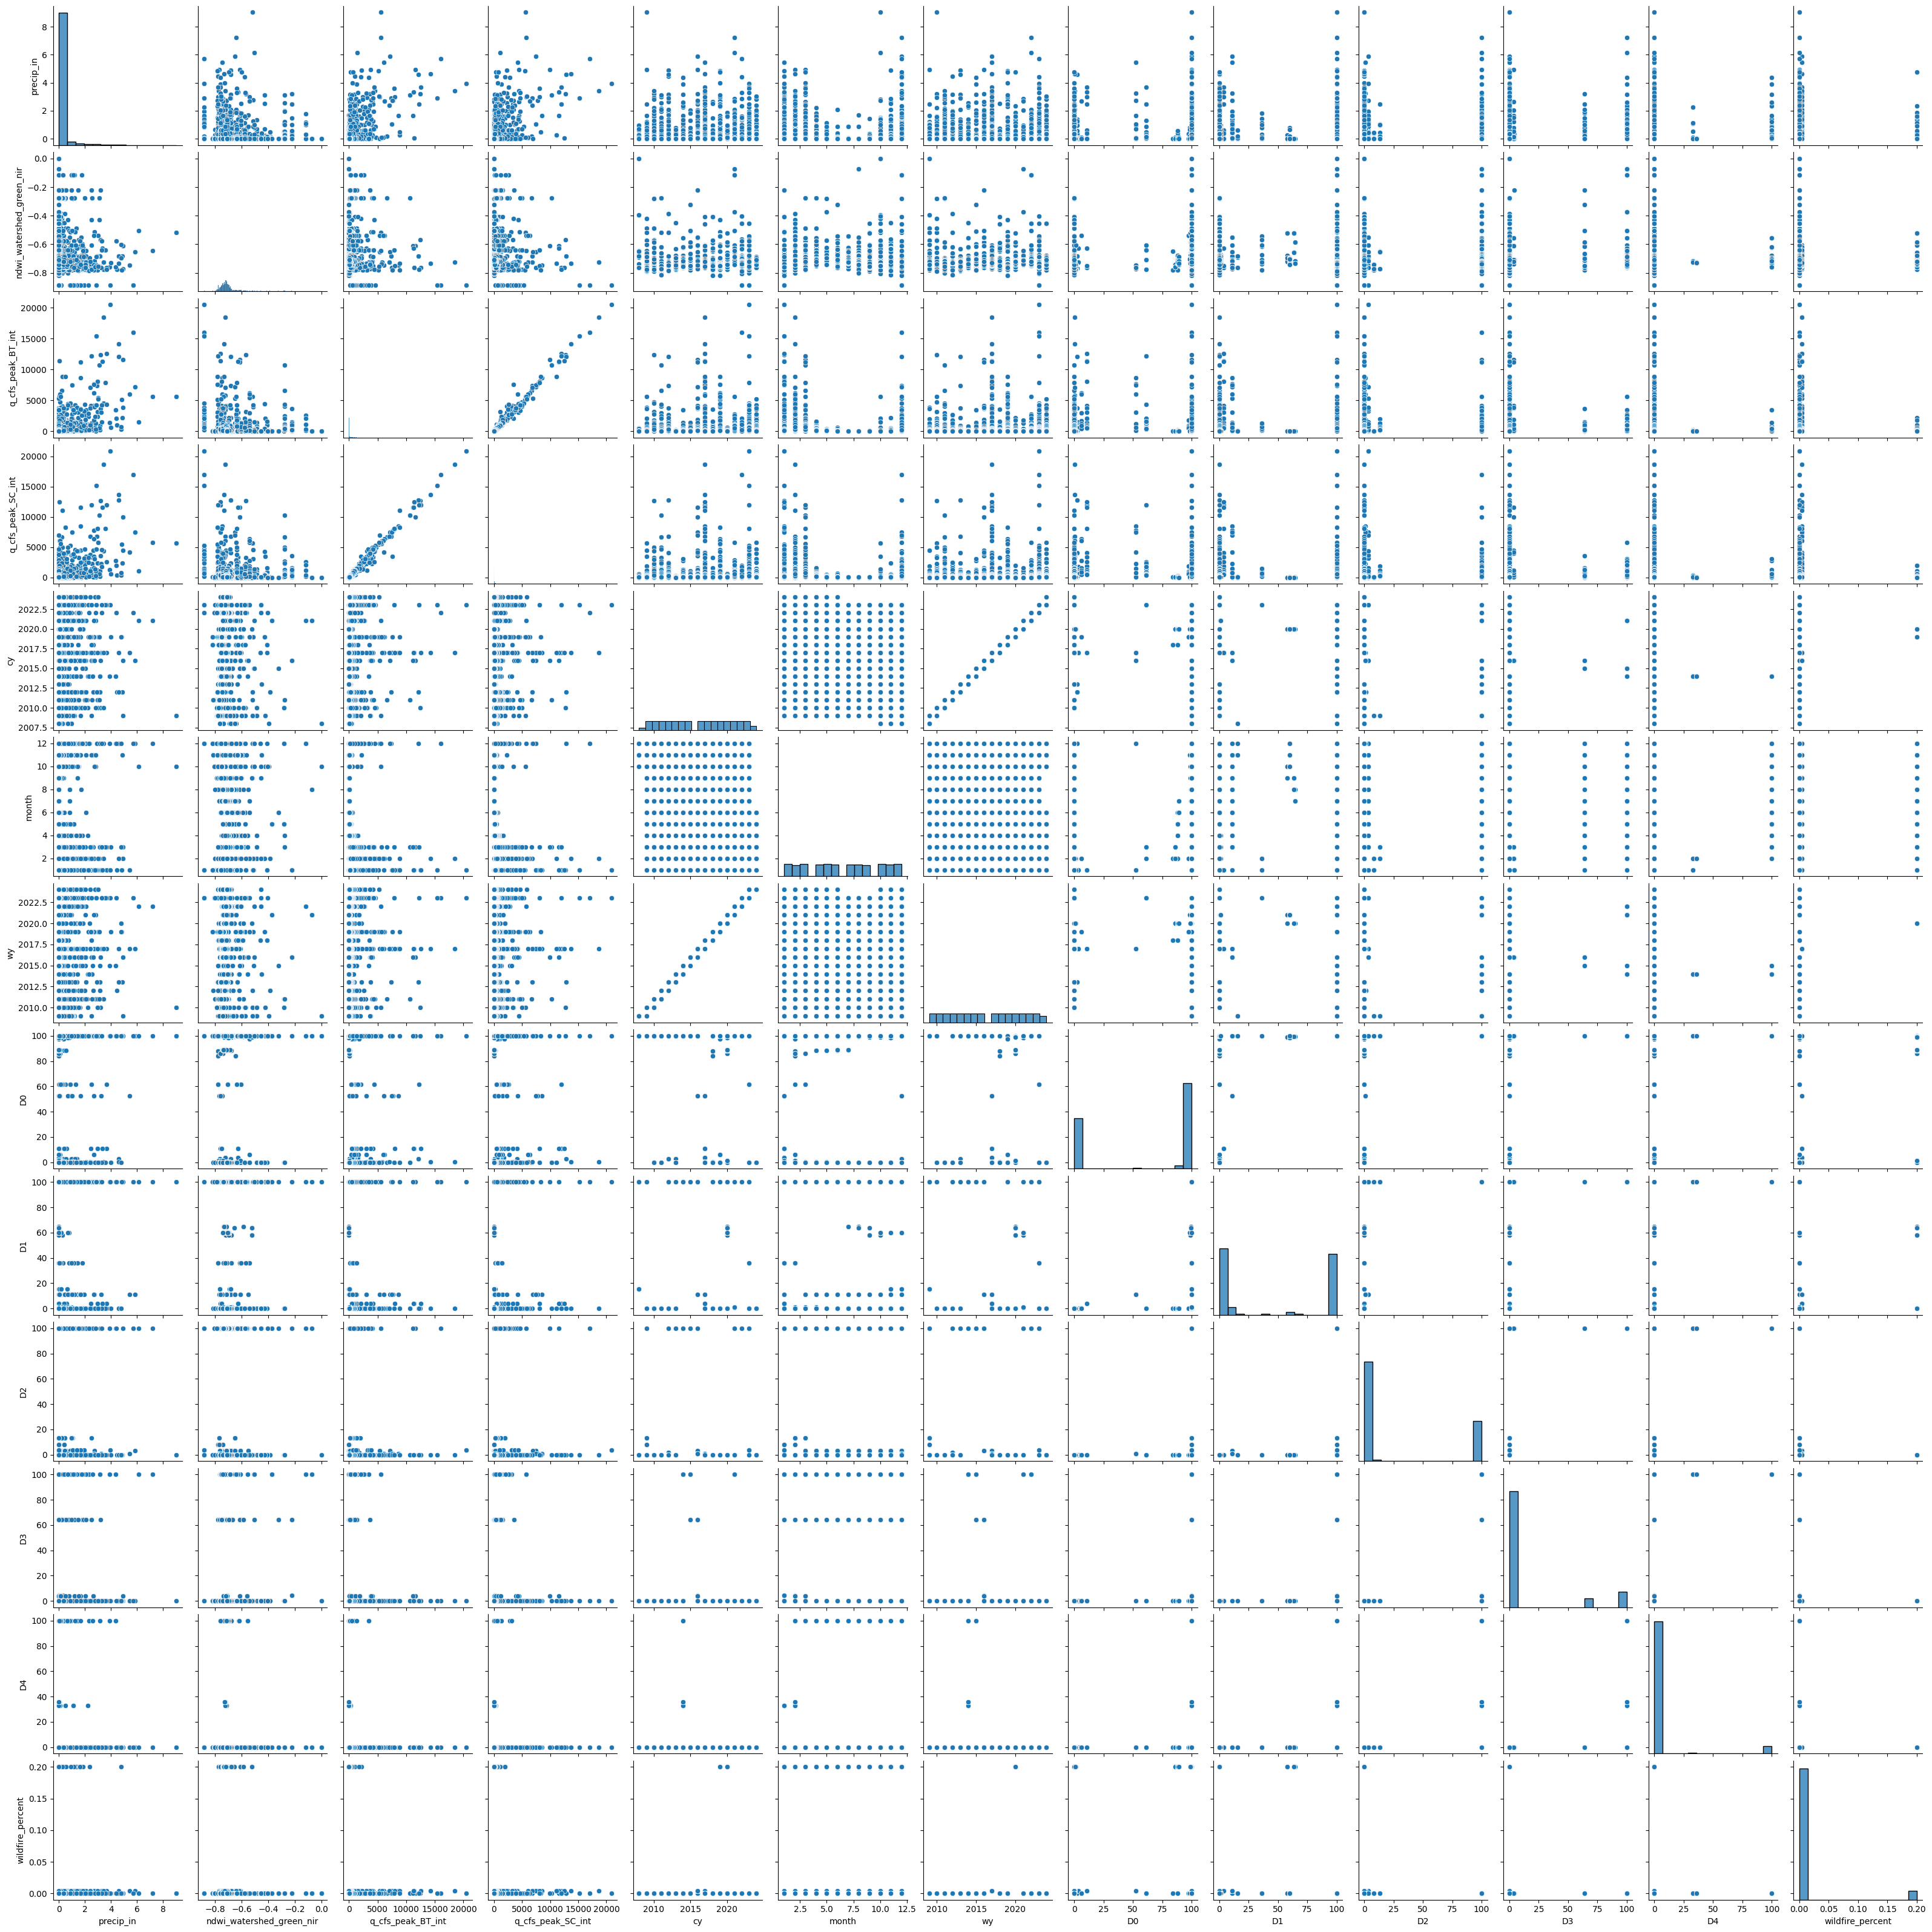

In [110]:
#plot var correlations
sns.pairplot(data)

<Axes: >

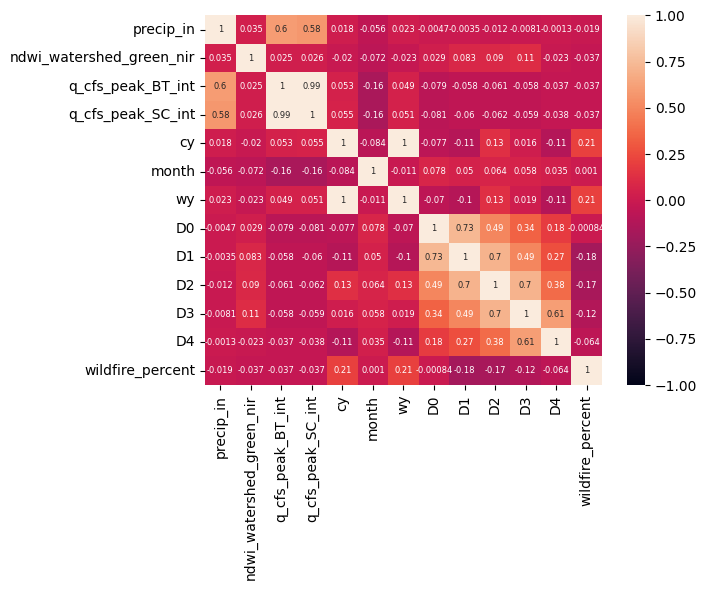

In [111]:
# plot correlation heatmap
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, annot_kws={"size":6}) 

,lag,correlation
0,0,0.575809
1,1,0.4437
15,15,0.406403
29,29,0.403663
43,43,0.418179
57,57,0.412058
71,71,0.416749
85,85,0.443172
99,99,0.437447
113,113,0.437759


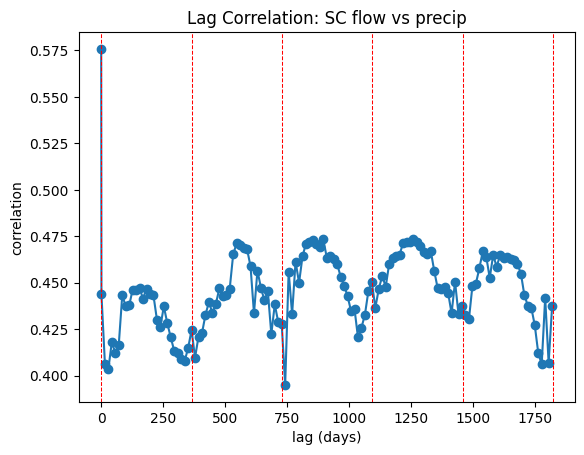

In [112]:
# calc lag correlation w precip, plot
lag_step = np.arange(1, 365*5, 14)
lag_step
lags_out = pd.DataFrame(columns=['lag', 'correlation'])
lags_out.loc[0, :] = [0, np.corrcoef(data['q_cfs_peak_SC_int'], data.precip_in)[1,0]]
for lag in lag_step:
    data_lag = data.copy()
    data_lag['q_cfs_peak_BT_int'] = data_lag['q_cfs_peak_BT_int'].diff(lag)
    data_lag.dropna(inplace=True)
    lags_out.loc[lag, :] = [lag, np.corrcoef(data_lag['q_cfs_peak_BT_int'], data_lag['precip_in'])[1,0]]
    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out['lag'], lags_out['correlation'],  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.set_title('Lag Correlation: SC flow vs precip')
for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)
lags_out.head(20)

,lag,correlation
0,0,0.026433
1,1,-0.00011
15,15,0.009102
29,29,-0.00609
43,43,-0.011988
57,57,0.00409
71,71,0.01004
85,85,0.024492
99,99,0.025977
113,113,0.030069


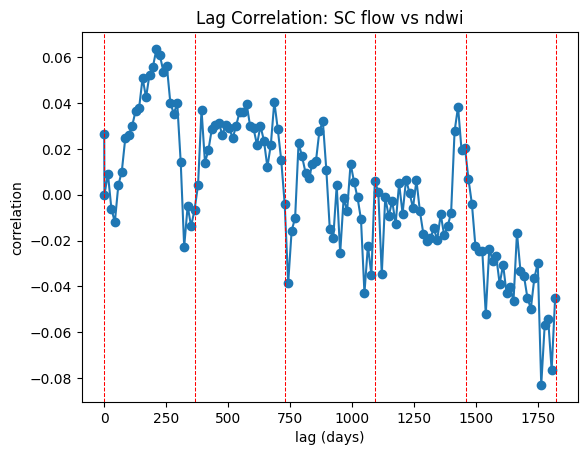

In [115]:
# calc lag correlation with ndwi, plot
lag_step = np.arange(1, 365*5, 14)
lag_step
lags_out = pd.DataFrame(columns=['lag', 'correlation'])
lags_out.loc[0, :] = [0, np.corrcoef(data['q_cfs_peak_SC_int'], data['ndwi_watershed_green_nir'])[1,0]]
for lag in lag_step:
    data_lag = data.copy()
    data_lag['q_cfs_peak_BT_int'] = data_lag['q_cfs_peak_BT_int'].diff(lag)
    data_lag.dropna(inplace=True)
    lags_out.loc[lag, :] = [lag, np.corrcoef(data_lag['q_cfs_peak_BT_int'], data_lag['ndwi_watershed_green_nir'])[1,0]]
    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out['lag'], lags_out['correlation'],  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.set_title('Lag Correlation: SC flow vs ndwi')
for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)
lags_out.head(20)

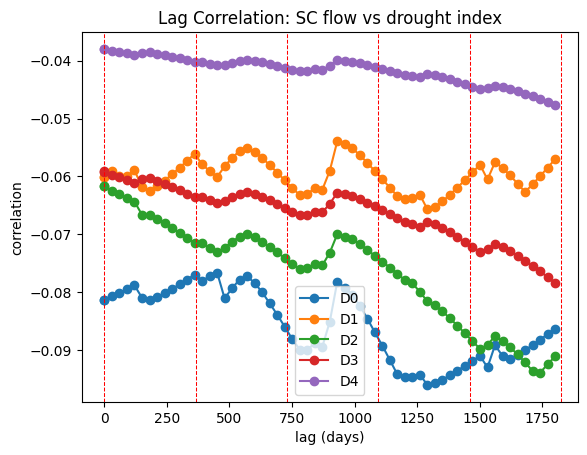

In [113]:
#lag correlation with each Drought category
lag_step = np.arange(1, 365*5, 30)
d_cat_list = ['D0', 'D1', 'D2', 'D3', 'D4']
lags_out = pd.DataFrame(columns=d_cat_list)

for d in d_cat_list:
    lags_out.loc[0, d] = np.corrcoef(data['q_cfs_peak_SC_int'], data[d])[1,0]
    
for lag in lag_step:
    data_lag = data.copy()
    data_lag['q_cfs_peak_BT_int'] = data_lag['q_cfs_peak_BT_int'].diff(lag)
    data_lag.dropna(inplace=True)
    
    for d in d_cat_list:
        lags_out.loc[lag, d] = np.corrcoef(data_lag['q_cfs_peak_SC_int'], data_lag[d])[1,0]

    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out.index, lags_out,  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.legend(lags_out.columns)
ax.set_title('Lag Correlation: SC flow vs drought index')

for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)

In [116]:
#save data
data.to_csv('01_data.csv')

## Summary
Data resampled to daily - laptop kernel was crashing with 15 min data when running model

No missing data or outliers. 
Lag correlations suggest that precipitation and streamflow correlation peaks about 4 months prior, so will need to look back at least 4 months for LSTM models. 
Drought index vs streamflow shows similar results; with small bumps in correlation around 4 months prior. 

Other potential data to add if model doesn't perform well: precipitation or humidity. Soil moisture metric? Maybe watershed scale NDWI? 